In [1]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import h5py
import glob
import pmefm
reload(pmefm)
from collections import OrderedDict
from kpfm.util import h5filename
from kpfm.util import kpfm_data
import sigutils
from kpfm import lockin
from kpfm import util
reload(util)
reload(lockin)

ks = 14950.0

from scipy import integrate
def ck(f, x0, A, k):
    out = integrate.quad(lambda theta: f(x0 + A * np.cos(theta)) * np.cos(theta*k), -np.pi, np.pi)
    if k == 0:
        return out[0]/(2*np.pi)
    else:
        return out[0]/np.pi

@h5filename
def _h5toPMEFM(f):
    phi_t = f['CPD'][:]
    fs = f.attrs['Inputs.Scan rate [Hz]']
    dt = 1/fs
    T = phi_t.size * dt
    fx = f.attrs['Inputs.Pos Mod Freq (Hz)']
    x_m = f.attrs['Inputs.Pos Mod rms (V)'] * np.sqrt(2) * 0.2 * 15 * 0.167 
    x_tot = (f.attrs['Inputs.End scan [V]'] -
             f.attrs['Inputs.Start scan [V]']) * 0.125
    v_tip = x_tot / T

    return {'fs': fs, 'fx': fx, 'v_tip': v_tip, 'x_m': x_m, 'phi_t': phi_t}

In [18]:
m = kpfm_data("../data/KPFM/Feb 17 16-47  image 1.txt")

In [19]:
m.dx = np.mean(np.gradient(m.vx)) * 0.125
m.dy = np.mean(np.gradient(m.vy)) * 0.125

In [20]:
Ex, Ey = np.gradient(m.ch1)
m.Ex, m.Ey = Ex/m.dx, Ey/m.dy

In [21]:
Vx, Vy = np.meshgrid(m.vx, m.vy)

In [22]:
y = (m.vx - m.vx.mean()) * 0.125
x = (m.vy - m.vy.min()) * 0.125
Vx_ = (Vx - Vx.mean()) * 0.125
Vy_ = (Vy - Vy.min()) * 0.125
X, Y = Vy_, Vx_

In [23]:
xx = np.linspace(2, 9, 200)

In [24]:
from scipy import interpolate

In [25]:
interp2d = interpolate.RectBivariateSpline(x, y, m.ch1.T)

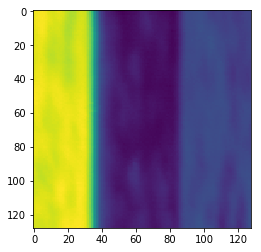

In [26]:
plt.imshow(m.ch1)

In [27]:
CH1 = np.fft.fft2(m.ch1.T)

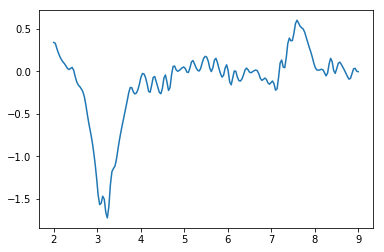

In [28]:
plt.plot(xx, interp2d.ev(xx, -2.5, dx=1))

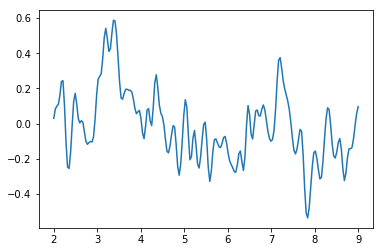

In [29]:
plt.plot(xx, interp2d.ev(xx, -2.5, dy=1))

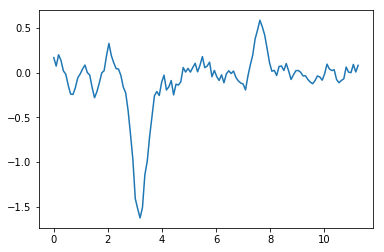

In [30]:
plt.plot(x, interp2d.ev(x, -2.5, dx=1))

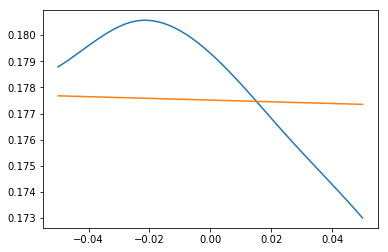

In [31]:
A = 0.05
yA = np.linspace(-A, A, 51)

c1 = ck(lambda x: interp2d(2.0, x, grid=False), 0, A, 1)
c0 = ck(lambda x: interp2d(2.0, x, grid=False), 0, A, 0)
plt.plot(yA, interp2d(2.0, yA, grid=False))
plt.plot(yA, c0 + c1*yA)

In [46]:
x00 = xx
y0 = -2.5

y00 = interp2d(xx, y0, grid=False)
x01 = xx
y01 = -interp2d.ev(xx, y0, dx=1)
x02 = xx
y02 = -interp2d.ev(xx, y0, dy=1)

A = 0.06

yA = np.linspace(-A, A, 51)

c1 = lambda x: ck(lambda y: interp2d(x, y0+y, grid=False), 0, A, 1)
c0 = lambda x: ck(lambda y: interp2d(x, y0+y, grid=False), 0, A, 0)


c0x = np.array([c0(x) for x in xx])
c1x = -np.array([c1(x) for x in xx])/A





In [47]:
c0x_d = -np.gradient(c0x)/np.gradient(xx)

In [48]:
d = np.mean(np.gradient(xx))
freq = np.fft.rfftfreq(y00.size, d=d)

mV = 1000

PHI = np.fft.rfft(y00.squeeze()*signal.blackman(y00.size)) / y00.size * d * mV
C0  = np.fft.rfft(c0x*signal.blackman(y00.size)) / c0x.size * d * mV
EX = np.fft.rfft(y01.squeeze()*signal.blackman(y00.size)) / y01.size * d * mV * A
C0X = np.fft.rfft(c0x_d*signal.blackman(y00.size)) / c0x_d.size * d * mV * A

EY = np.fft.rfft(y02.squeeze()*signal.blackman(y00.size)) / y02.size * d * mV * A
C1 = np.fft.rfft(c1x*signal.blackman(y00.size)) / c1x.size * d* mV * A

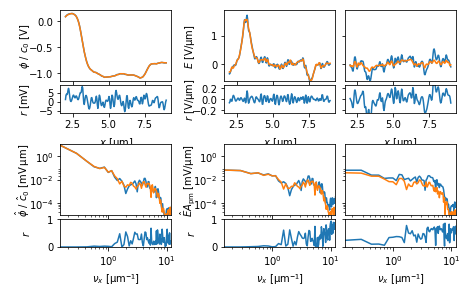

In [49]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(7.5,4.5),
                         gridspec_kw={'height_ratios': (1, 0.35, 1, 0.35)}
                        )
axes[0, 0].plot(x00, y00)
axes[0, 0].plot(xx, c0x)
axes[0, 0].set_ylabel(u"$\\phi$ / $c_0$ [V]")
axes[0, 1].plot(x01, y01)
axes[0, 1].plot(xx, c0x_d)
axes[0, 2].plot(x02, y02)
axes[0, 2].plot(xx, c1x)
axes[1, 0].set_ylabel(u"$r$ [mV]")
axes[1, 0].plot(xx, (y00.squeeze() - c0x) *1e3)

axes[1, 2].plot(x02, y02-c1x)
axes[1, 1].plot(x01, y01-c0x_d)
axes[2, 0].loglog(freq, abs(PHI))
axes[2, 0].loglog(freq, abs(C0))
axes[3, 0].semilogx(freq, abs(abs(PHI) - abs(C0)) / (abs(PHI) + abs(C0)))

axes[2, 1].loglog(freq, abs(EX))
axes[2, 1].loglog(freq, abs(C0X))

axes[3, 1].semilogx(freq, abs(abs(EX) - abs(C0X)) / (abs(EX) + abs(C0X)))

axes[2, 2].loglog(freq, abs(EY))
axes[2, 2].loglog(freq, abs(C1))


axes[3, 2].semilogx(freq, abs(abs(EY) - abs(C1)) / (abs(EY) + abs(C1)))

# axes[3, 2].semilogx(freq, abs(abs(EY) - abs(C1)) / (abs(EY) + abs(C1)))


for i, axr in enumerate(axes):
    for j, ax in enumerate(axr):
        if i >= 2:
            ax.set_xlim(0.15, 12)
            if (i == 2):
                ax.set_ylim(1e-5, 1e1)
            
            if i == 2:
                ax.set_xticklabels([''])
            
            
        if j == 0:
            pos1 = ax.get_position()
            pos2 = [pos1.x0, pos1.y0, pos1.width*0.9, pos1.height]
            ax.set_position(pos2)
            
        
        if j == 1:
            pos1 = ax.get_position()
            pos2 = [pos1.x0+0.03, pos1.y0, pos1.width*0.9, pos1.height]
            ax.set_position(pos2)
            
        
        if j == 2:
            pos1 = ax.get_position()
            pos2 = [pos1.x0-0.02, pos1.y0, pos1.width*0.9, pos1.height]
            ax.set_position(pos2)
        
        
        squeeze = 0.9
        if i == 0:
            ax.set_xticklabels([''])
            pos1 = ax.get_position()
            pos2 = [pos1.x0, pos1.y0, pos1.width, pos1.height*squeeze]
            ax.set_position(pos2)
        
        if i == 1:
            pos1 = ax.get_position()
            pos2 = [pos1.x0, pos1.y0+0.02, pos1.width, pos1.height]
            ax.set_position(pos2)
            
        
        if i == 2:
            pos1 = ax.get_position()
            pos2 = [pos1.x0, pos1.y0-0.02, pos1.width, pos1.height*squeeze]
            ax.set_position(pos2)
        
        if i == 3:
            pos1 = ax.get_position()
            pos2 = [pos1.x0, pos1.y0, pos1.width, pos1.height]
            ax.set_position(pos2)
            
        if i == 1 and j >= 1:
            ax.set_yticks([-0.2, 0, 0.2])
        
        if i == 0:
            
            if j >= 1:
                ax.set_ylim(-0.6,1.9)
        
        if i == 1 and j == 1:
            ax.set_ylabel(u"$r$ [V/µm]")
            
        if i == 3 and j == 1:
            ax.set_ylabel(u"$r$")
        
        if i == 1:
            if j >= 1:
                ax.set_ylim(-0.25, 0.25)
        
        if i == 3:
            ax.set_ylim(0, 1)
        
        if j == 2:
            ax.set_yticklabels([''])
        
        if i == 0 and j == 1:
            ax.set_ylabel(u"$E$ [V/µm]")
            
        if i == 1:
            ax.set_xlabel(u"$x$ [µm]")
        
        if i == 3:
            ax.set_xlabel(u"$\\nu_{x}$ [µm⁻¹]")
            if j == 0:
                ax.set_ylabel(u"$r$")
        
        if i == 2 and j == 0:
            ax.set_ylabel(u'$\hat{\phi}$ / $\hat{c}_0$ [mV$\\,$µm]')
            
        if i == 2:
            ax.set_yticks([1e-4, 1e-2, 1])
            
        
        if i == 2 and j == 1:
            ax.set_ylabel(u"$\hat{E} A_{\mathrm{pm}}$ [mV/µm]")
        
        

util.align_labels(axes[1], lim=157, axis='x')
util.align_labels(axes.T[1], lim=197, axis='y')
util.align_labels(axes.T[0], lim=32.5, axis='y')


In [51]:

fig.savefig('../figs/SI-phi-c-x.pdf')

In [52]:
! open '../figs/SI-phi-c-x.pdf'

In [383]:
!cp ../figs/SI-phi-c-x.pdf \
    /Users/ryandwyer/Dropbox/_JAM_MS__Dwyer201705__PMKPFM__figs/